# Deep Learning - Optimasi Akurasi Metode Convolutional Neural Network untuk Identifikasi Jenis Sampah
- I Komang Cleon Kalea
- 2105551090
- Deep Learning (B)

## Import Library

In [1]:
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
sys.setrecursionlimit(10000)

## Function

### Function: Plot Confusion Matrix

In [2]:
def plot_cm(model, test_generators):

    predictions = model.predict(test_generators)
    true_labels = test_generators.classes

    predicted_labels = (predictions > 0.5).astype('int32')

    accuracy = f"Accuracy: {accuracy_score(true_labels, predicted_labels)}"
    print(accuracy)
    
    cm = confusion_matrix(true_labels, predicted_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generators.class_indices)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


### Function: Plot Training History

In [3]:
def plot_training(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


### Function: Neural Network Process Visualization

In [4]:
def visualize_neural_network_process(img_path, model):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    activations = activation_model.predict(img_array)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    layer_names = [layer.name for layer in model.layers]

    for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
        if len(layer_activation.shape) == 4:
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // 16
            display_grid = np.zeros((size * n_cols, 16 * size))

            for col in range(n_cols):
                for row in range(16):
                    channel_image = layer_activation[0, :, :, col * 16 + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                row * size : (row + 1) * size] = channel_image

            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

## Data Preprocessing

In [5]:
root_path = ''
source_path = os.path.join(root_path, 'raw dataset')
data_source_path = os.path.join(source_path, 'organic-nonorganic')
clean_dataset = False
SPLIT_SIZE = 0.8

### Create New Dataset

In [6]:
def create_train_val_dir(root_path):
    training_paths = {}
    validation_paths = {}

    datasets_dir = os.path.join(root_path, 'dataset')
    organic_nonorganic_dir = os.path.join(datasets_dir, 'organic-nonorganic')

    if clean_dataset==True and os.path.exists(organic_nonorganic_dir)==True :
        shutil.rmtree(organic_nonorganic_dir)

    training_dir = os.path.join(organic_nonorganic_dir, 'training')
    validation_dir = os.path.join(organic_nonorganic_dir, 'validation')

    organik_training_dir = os.path.join(training_dir, 'organik')
    organik_validation_dir = os.path.join(validation_dir, 'organik')

    nonorganik_training_dir = os.path.join(training_dir, 'non_organik')
    nonorganik_validation_dir = os.path.join(validation_dir, 'non_organik')

    training_paths['training_organik_dir'] = organik_training_dir
    training_paths['training_non_organik_dir'] = nonorganik_training_dir
    validation_paths['validation_organik_dir'] = organik_validation_dir
    validation_paths['validation_non_organik_dir'] = nonorganik_validation_dir

    if clean_dataset == False:
        print("Directory already exist! using existing directory! SET 'clean_dataset=True' to remake the directories.")
        pass
    else:
        os.makedirs(organik_training_dir)
        os.makedirs(organik_validation_dir)
        os.makedirs(nonorganik_training_dir)
        os.makedirs(nonorganik_validation_dir)

    return training_dir, validation_dir, training_paths, validation_paths


In [7]:
training_dir, validation_dir, training_paths, validation_paths = create_train_val_dir(root_path=root_path)

Directory already exist! using existing directory! SET 'clean_dataset=True' to remake the directories.


### Data Preprocessing: Data Cleaning & Data Splitting

In [8]:
def copy_split_shuffle_data(data_source_path, training_paths, validation_paths, split_size):
    files = []
    pathsep = "\\"
    data_ = {}

    try:
        for path, dirs, files in os.walk(data_source_path):
            for file in files:
                sep_file = os.path.join(path, file)

                if os.path.getsize(sep_file) > 0:
                    key = path.split(pathsep)[len(path.split(pathsep))-1].lower().replace(' ', '_') + "_train_dir".lower()
                    if key in data_:
                        data_[key].append(sep_file)
                    else:
                        data_[key] = [sep_file]
                else:
                    print(f"File has no weight: {file}. IGNORING!")
    except Exception as e:
        print(f"An error occurred: {e}")

    data = {
        'organik_train_dir': data_['organik_train_dir'],
        'non_organik_train_dir': data_['non_organik_train_dir']
    }

    try:
        for files_list, train_path, val_path in zip (data.values(), training_paths.values(), validation_paths.values()):
            print(files_list)
            print(train_path)
            print(val_path)

            if train_path is not None and val_path is not None:
                random.shuffle(files_list)

                split_point = int(len(files_list) * split_size)

                train_files = files_list[:split_point]
                val_files = files_list[split_point:]

                for file in train_files:
                    filename = os.path.basename(file)
                    dest_file = os.path.join(train_path, filename)
                    shutil.copyfile(file, dest_file)
                    print(f"Filename: {filename} copied from {file} to {dest_file} (Train)")

                for file in val_files:
                    filename = os.path.basename(file)
                    dest_file = os.path.join(val_path, filename)
                    shutil.copyfile(file, dest_file)
                    print(f"Filename: {filename} copied from {file} to {dest_file} (Validation)")

            else:
                print(f"No destination path found for class: . Skipping copying.")

    except Exception as e:
        print(f"An error occurred during file copying: {e}")


In [23]:
if clean_dataset== True:
    copy_split_shuffle_data(data_source_path, training_paths, validation_paths, SPLIT_SIZE)


['raw dataset\\organic-nonorganic\\organik\\cardboard1.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard10.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard100.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard101.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard102.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard103.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard104.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard105.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard106.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard107.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard108.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard109.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard11.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard110.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard111.jpg', 'raw dataset\\organic-nonorganic\\organik\\cardboard112.jpg', 'raw datase

### Data Preprocessing: Data Augmentation

In [9]:
test_dir = 'dataset/organic-nonorganic-test'

def train_val_generator(train_dir, val_dir, test_dir):

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generators = train_datagen.flow_from_directory(
                            directory=train_dir,
                            target_size=(150,150),
                            batch_size=64,
                            class_mode='binary',
                        )

    val_generators = val_datagen.flow_from_directory(
                            directory=val_dir,
                            batch_size=32,
                            class_mode='binary',
                            target_size=(150, 150)
                        )
    
    test_generators = test_datagen.flow_from_directory(
                            directory=test_dir,
                            class_mode='binary',
                            target_size=(150, 150),
                            shuffle=False
    )
    

    return train_generators, val_generators, test_generators

In [10]:
train_generators, val_generators, test_generators = train_val_generator(training_dir, validation_dir, test_dir)

Found 1344 images belonging to 2 classes.
Found 336 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


## Model

### Model: Architecture before Hyperparameter Tuning (Paper)

In [2]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [3]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,151 (13.18 MB)

 Trainable params: 3,454,151 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

#### Model: Neural Network Process Visualization

1/1 [==============================] - 2s 2s/step


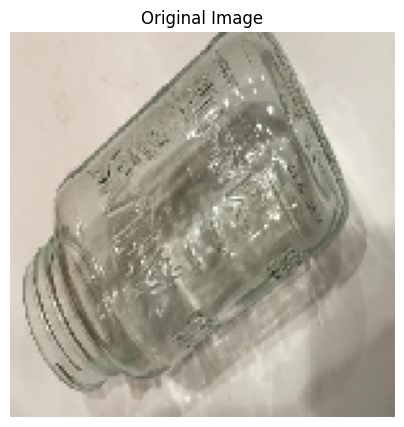

C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


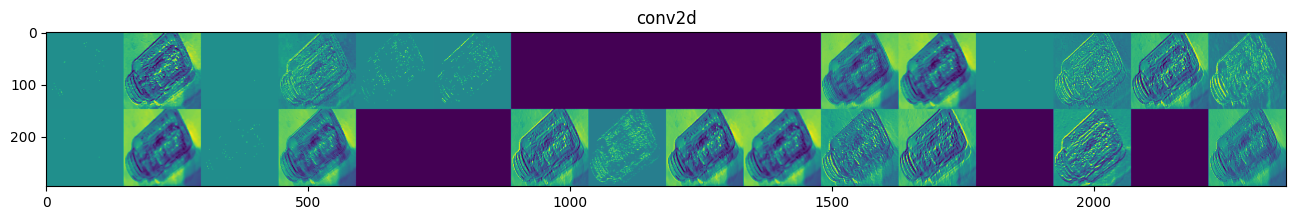

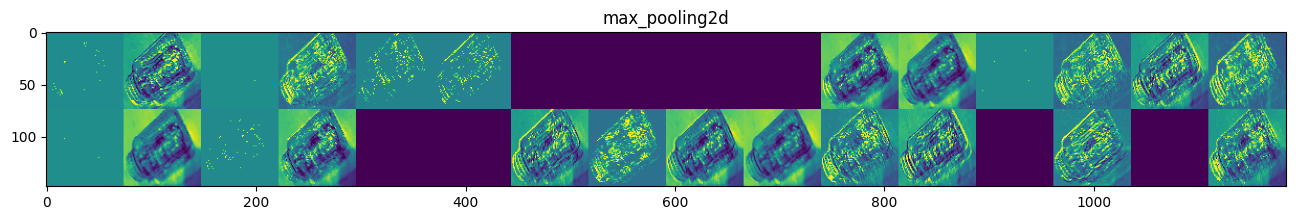

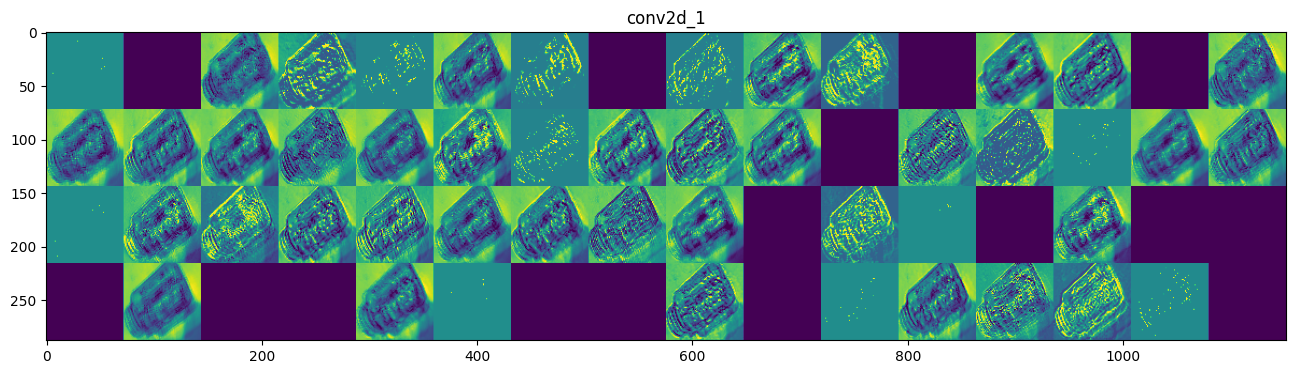

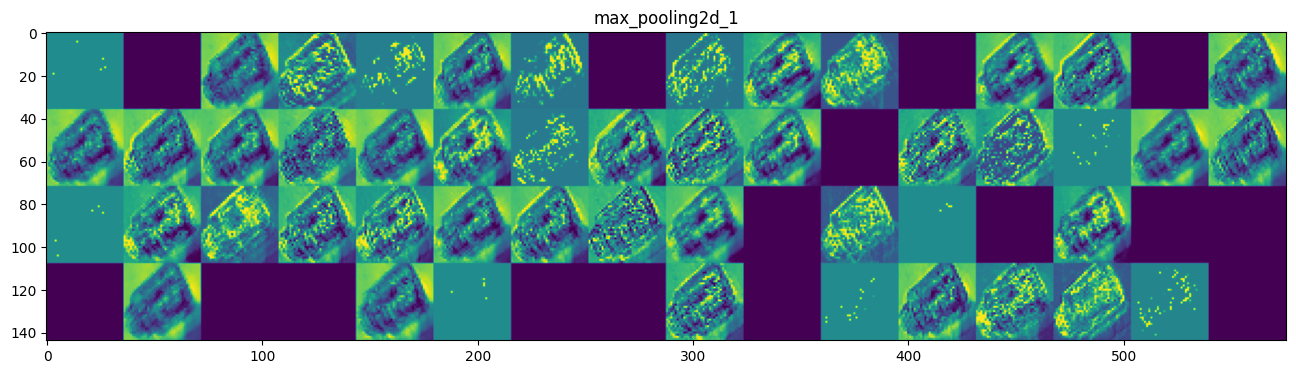

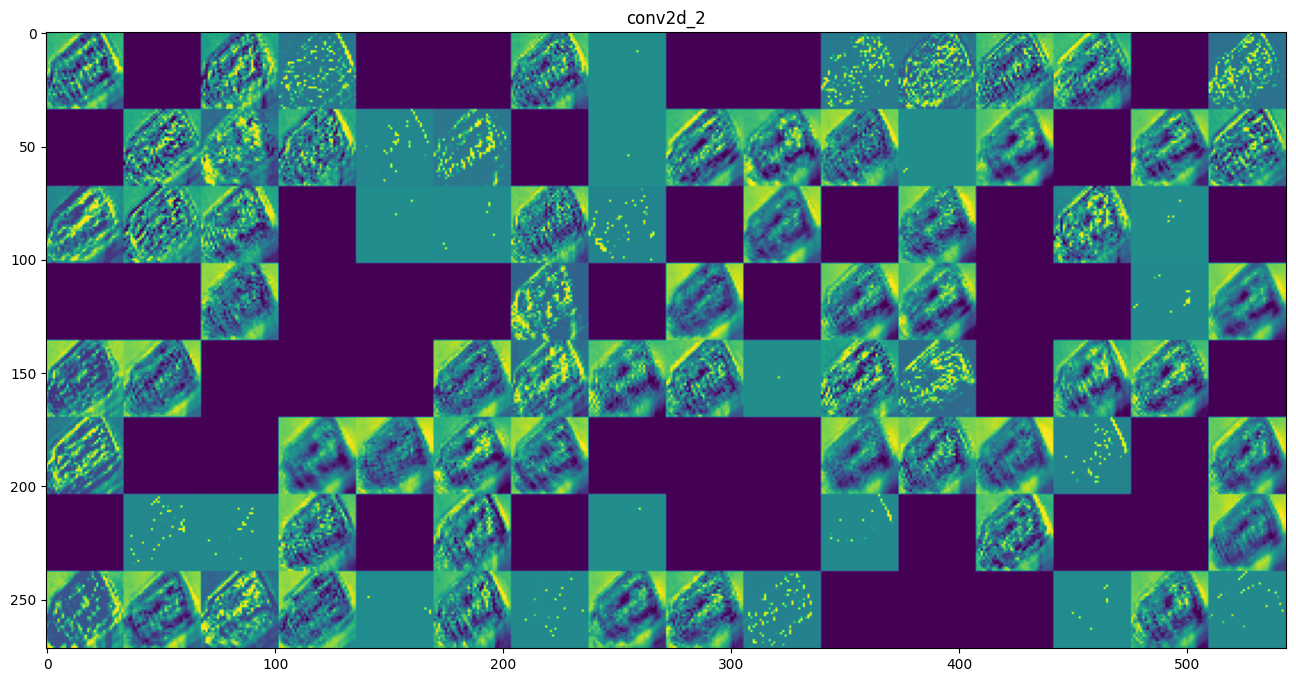

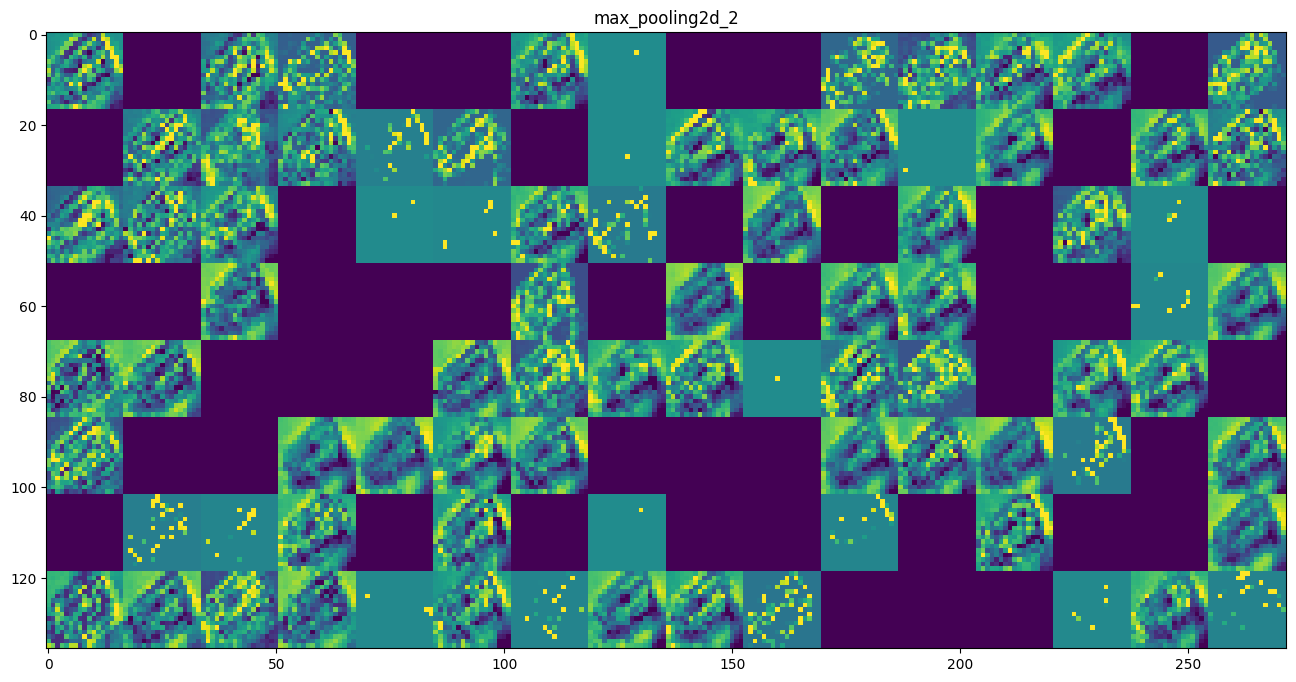

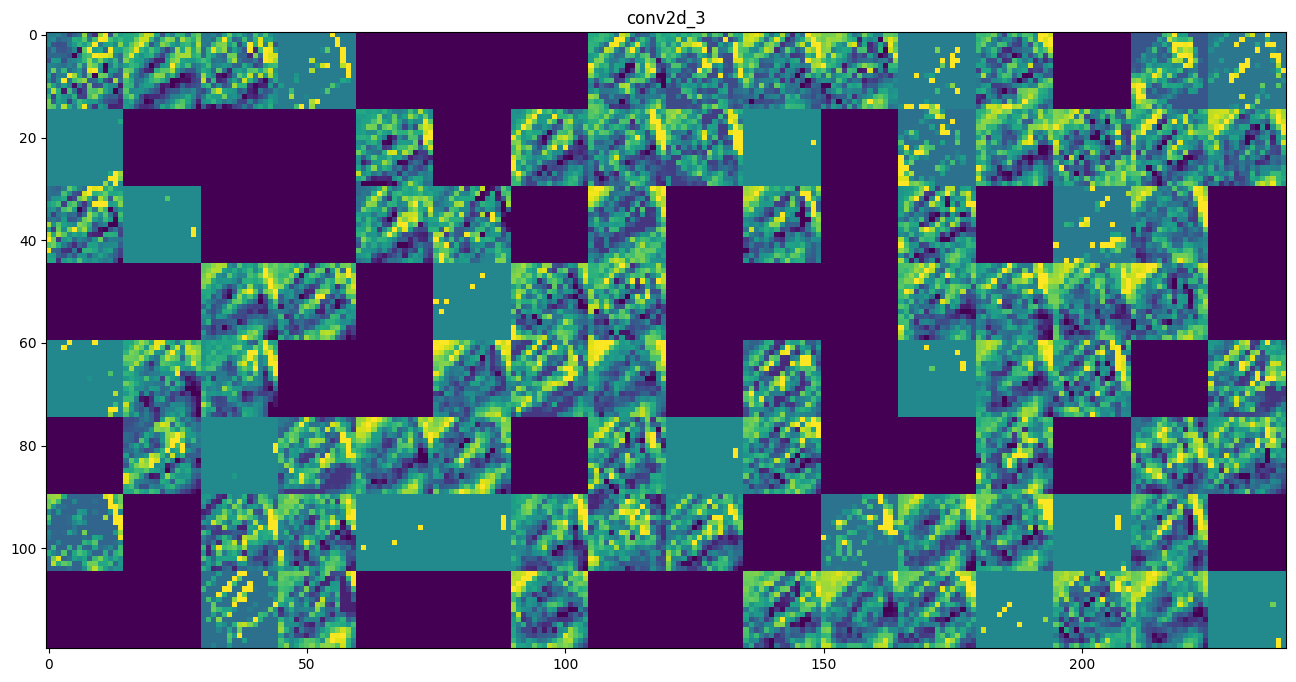

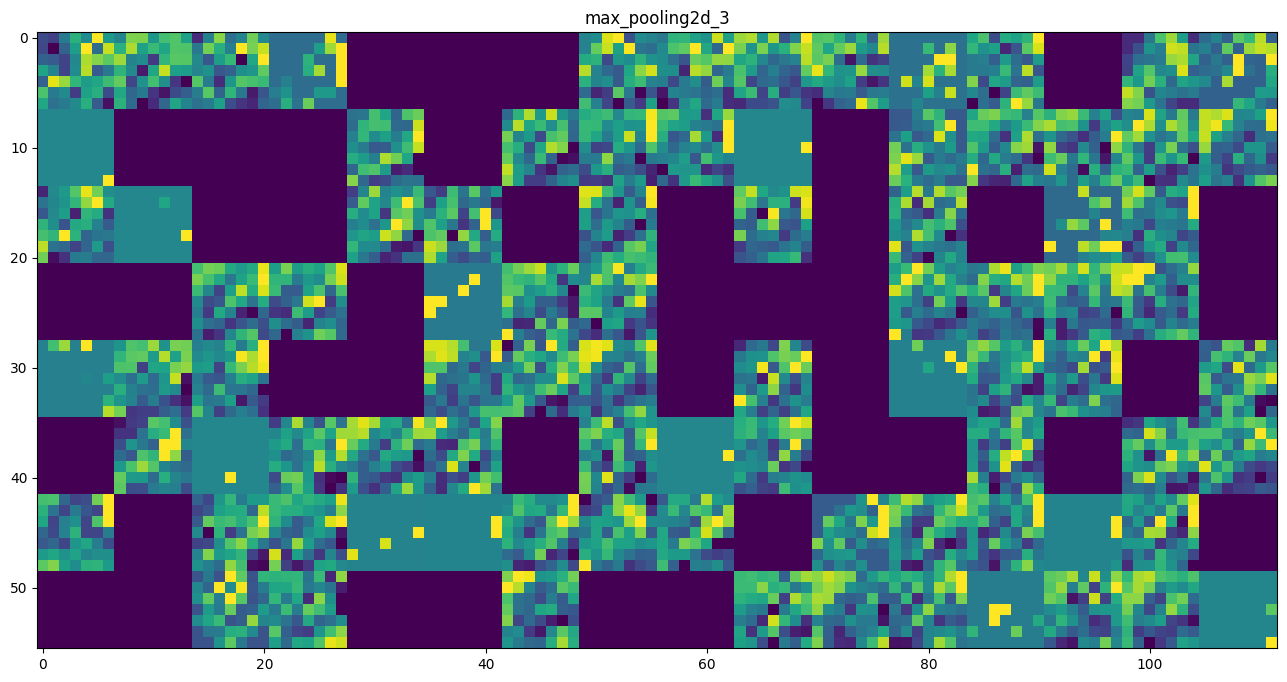

In [8]:
img_path = 'dataset/organic-nonorganic/validation/non_organik/glass35.jpg'
visualize_neural_network_process(img_path=img_path, model=model)

In [14]:
history = model.fit(train_generators, epochs=20, verbose=1, validation_data=val_generators, steps_per_epoch=25)

c:\Users\Kalea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/25 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.4980 - loss: 0.6930

c:\Users\Kalea\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.4981 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.4911 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.4838 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.5089 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.4669 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.4846 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.5046 - loss: 0.6931 - val_accuracy: 0.5000 - val_

#### Model: Before Hyperparameter Tuning Architecture Evaluation

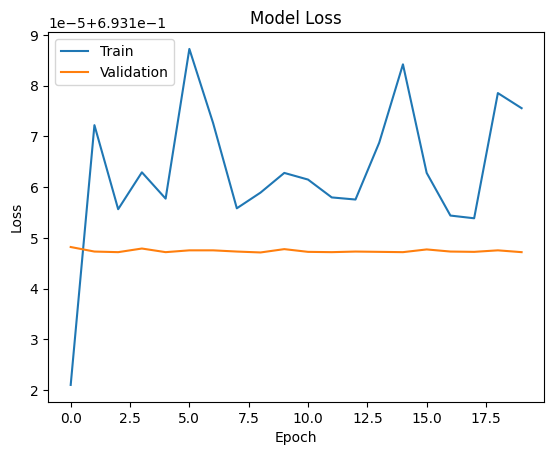

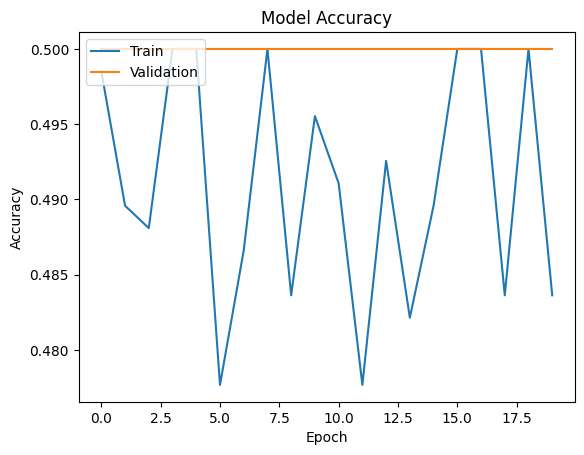

In [15]:
plot_training(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Accuracy: 0.5


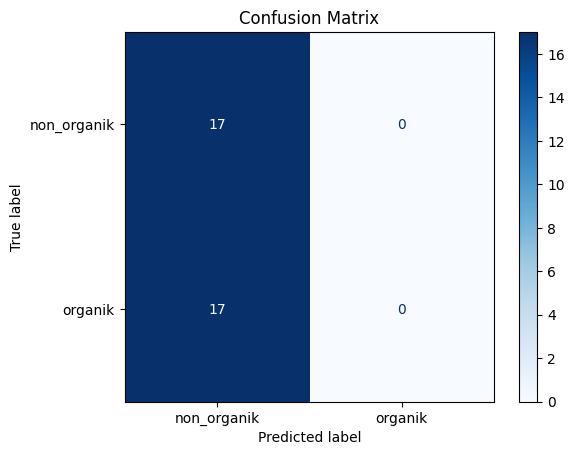

In [16]:
plot_cm(model=model, test_generators=test_generators)

### Model: Architecture after Hyperparameter Tuning (Paper)

In [4]:
def create_model_hyperparameter():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3),),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
model_hyperparameter = create_model_hyperparameter()
model_hyperparameter.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 35, 35, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 766,657 (2.92 MB)

 Trainable params: 766,657 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

#### Model: Neural Network After Hyperparameter Tuning Process Visualization

1/1 [==============================] - 0s 305ms/step


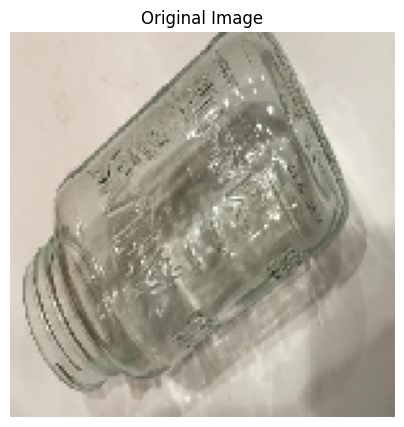

C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


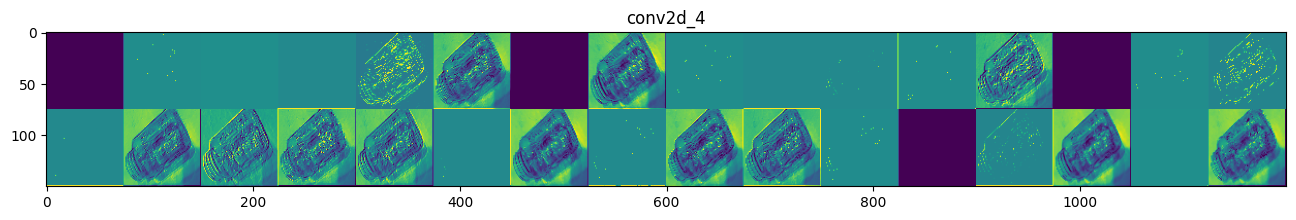

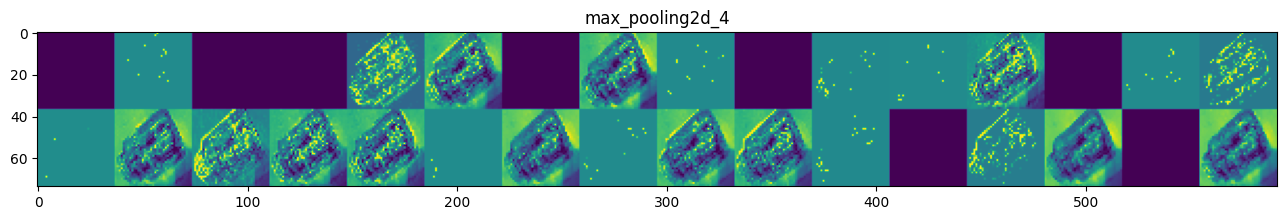

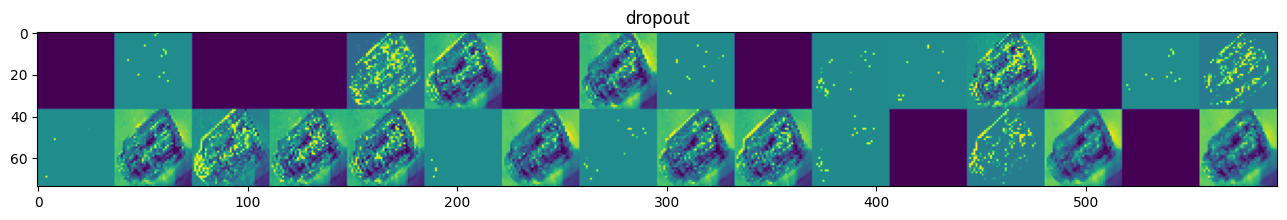

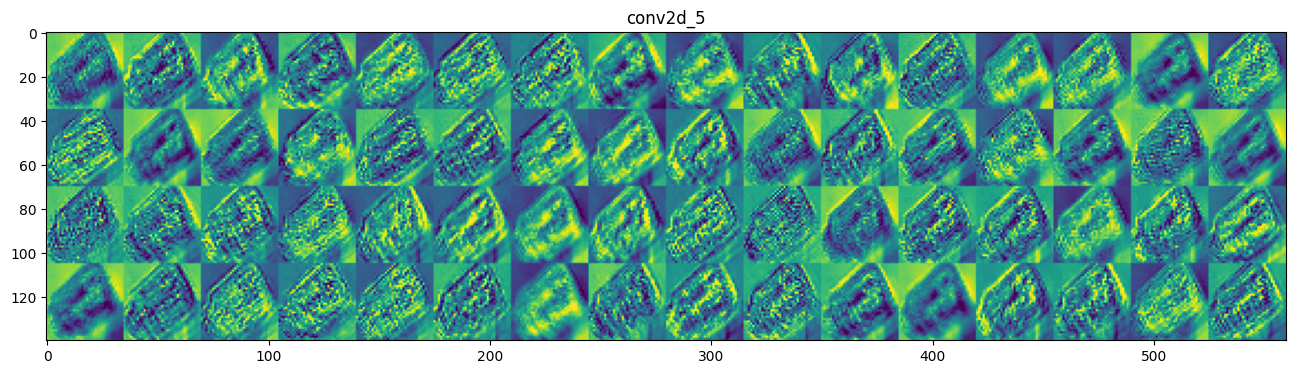

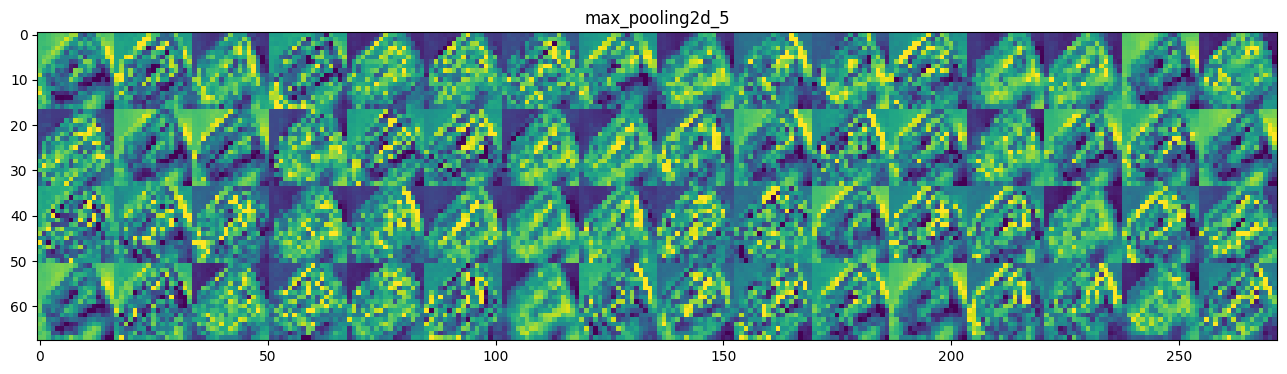

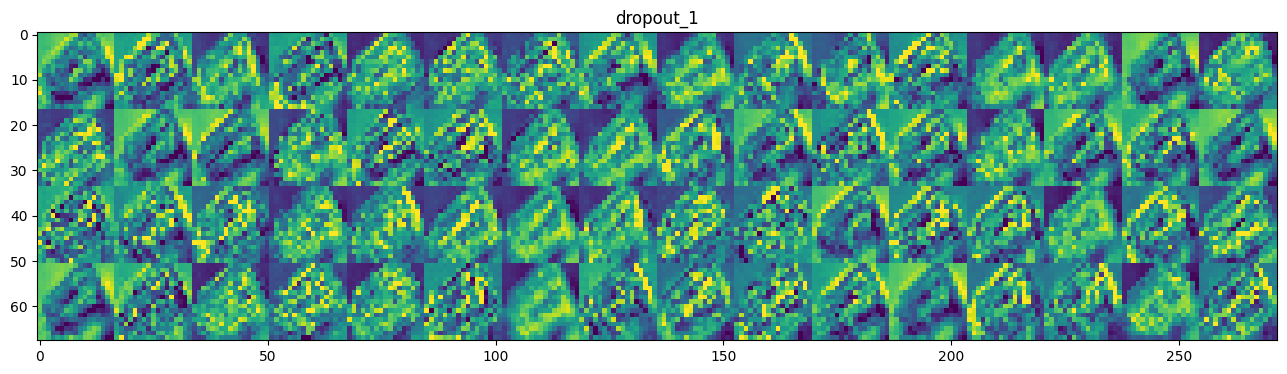

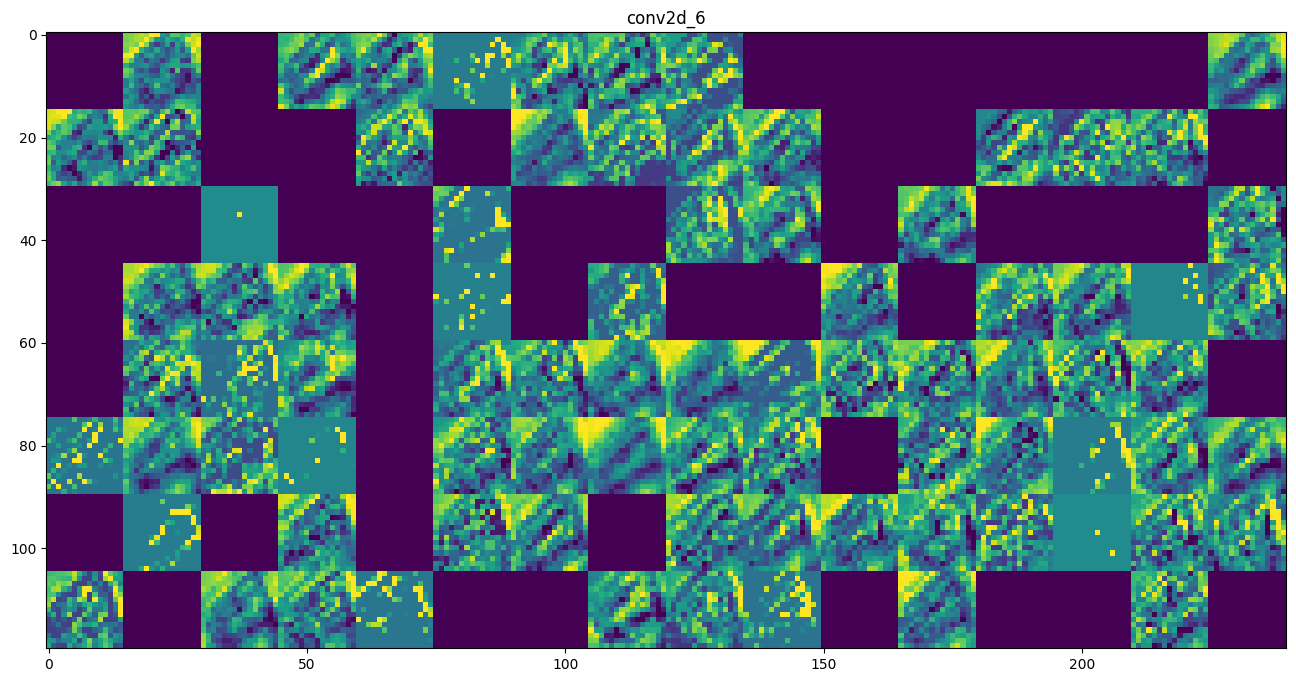

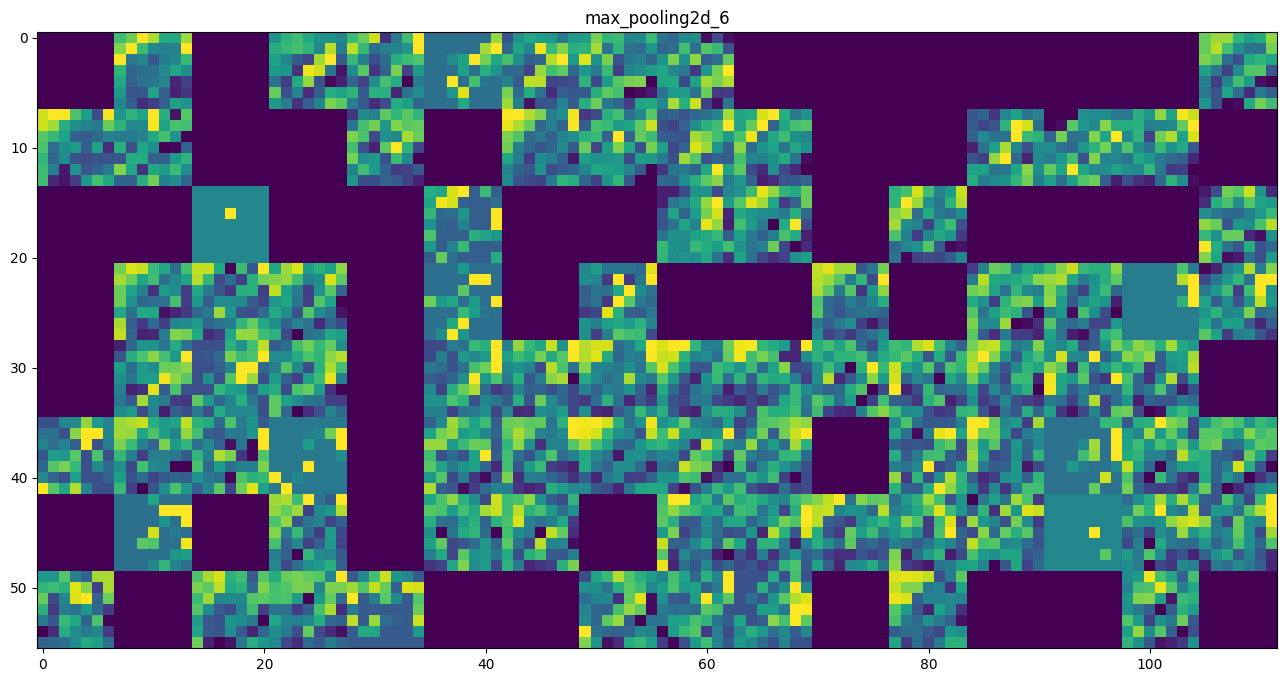

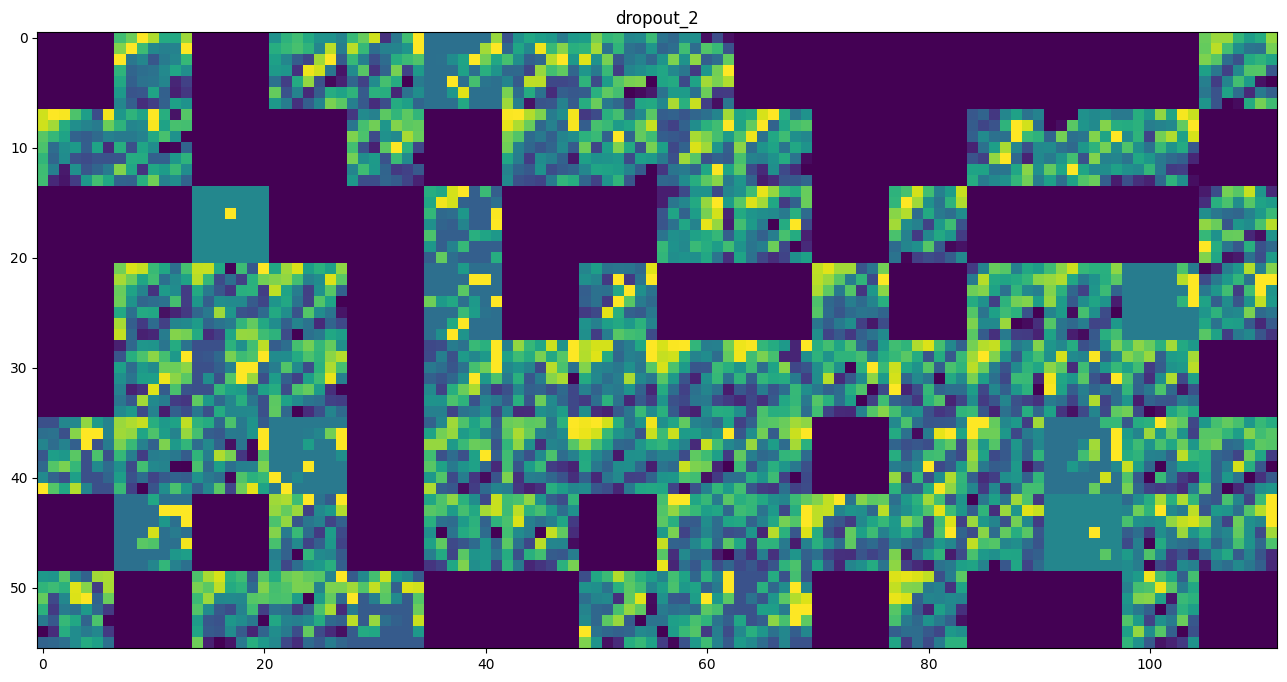

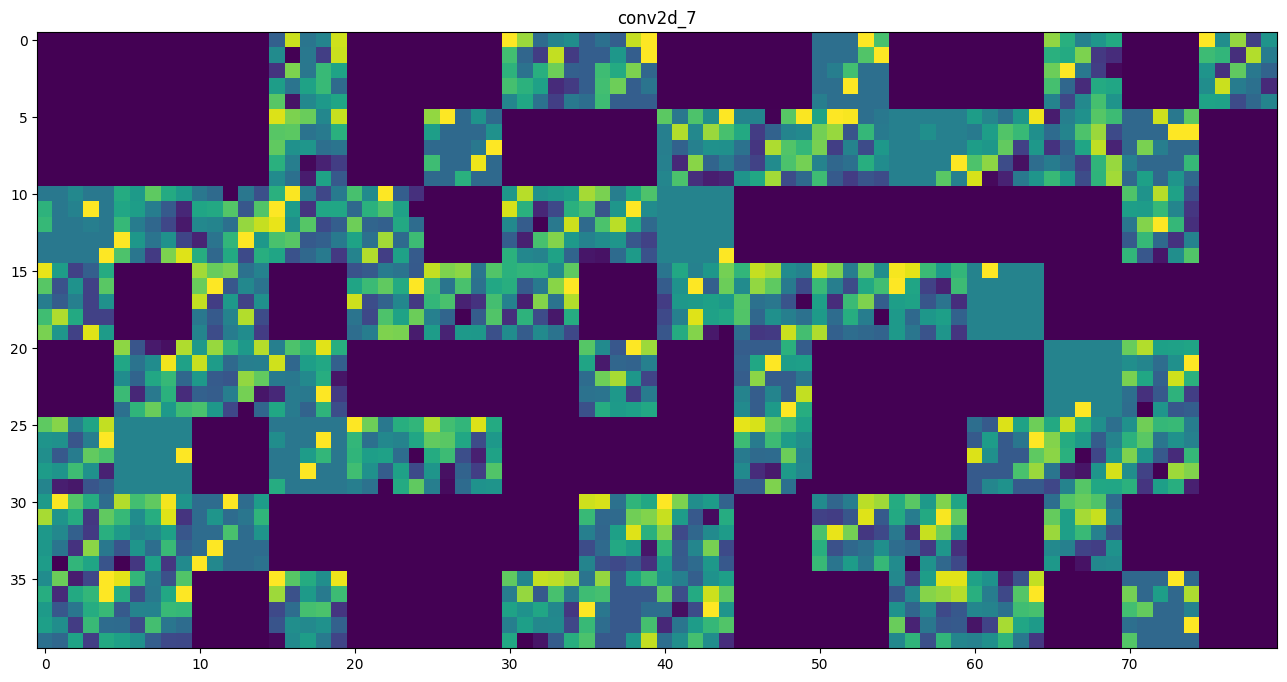

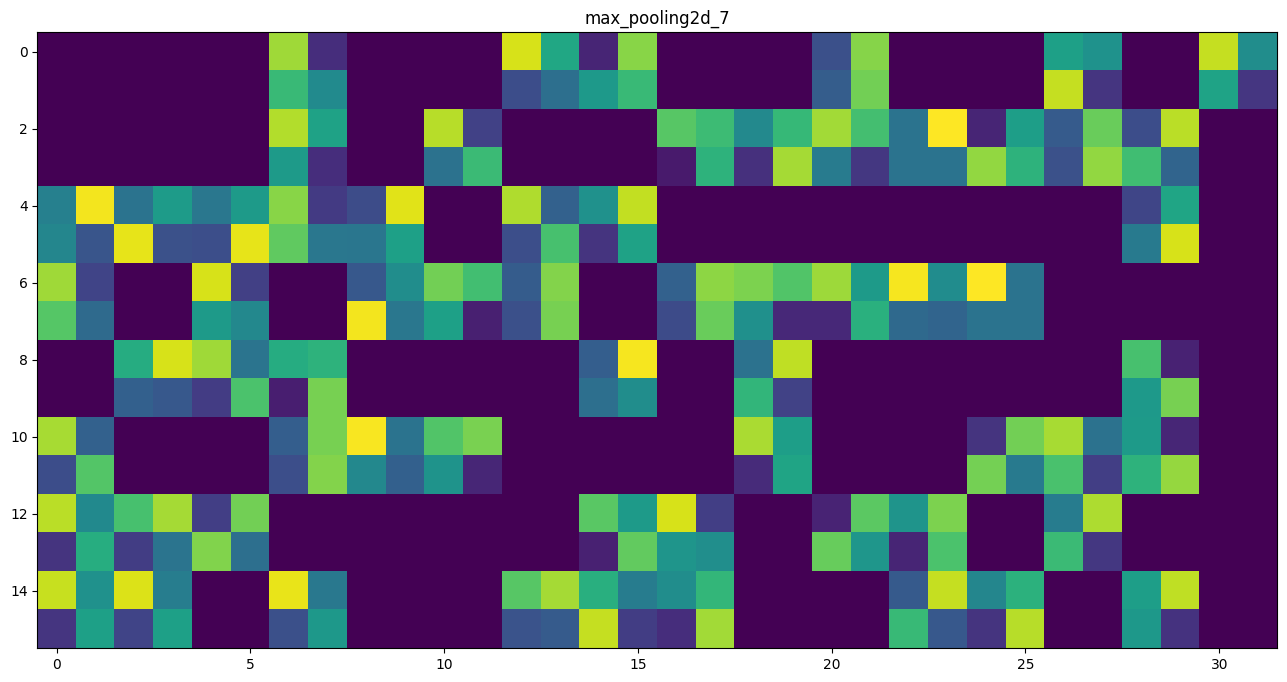

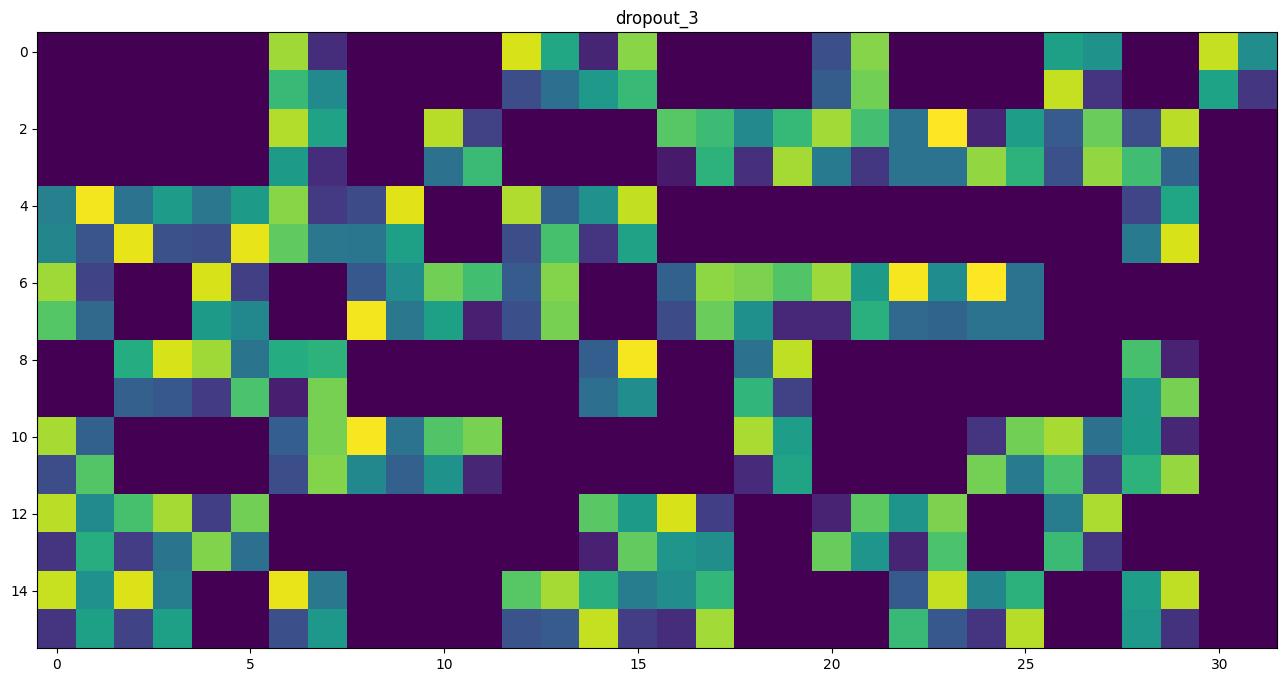

In [12]:
img_path = 'dataset/organic-nonorganic/validation/non_organik/glass35.jpg'
visualize_neural_network_process(img_path=img_path, model=model_hyperparameter)

In [22]:
history_hyperparameter = model_hyperparameter.fit(train_generators, epochs=20, verbose=1, validation_data=val_generators, steps_per_epoch=25)

Epoch 1/20
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4991 - loss: 0.7132

c:\Users\Kalea\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.5008 - loss: 0.7117 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.5464 - loss: 0.6799 - val_accuracy: 0.6518 - val_loss: 0.6647
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6203 - loss: 0.6572 - val_accuracy: 0.6756 - val_loss: 0.6233
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.6282 - loss: 0.6418 - val_accuracy: 0.6488 - val_loss: 0.6106
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.6833 - loss: 0.5830 - val_accuracy: 0.6815 - val_loss: 0.5972
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6986 - loss: 0.5861 - val_accuracy: 0.6726 - val_loss: 0.6363
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.7086 - loss: 0.5513 - val_accuracy: 0.6429 - val_loss: 0.6038
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.6761 - loss: 0.5928 - val_accuracy: 0.6786 - val_

#### Model: Architecture after Hyperparameter Tuning Evaluation

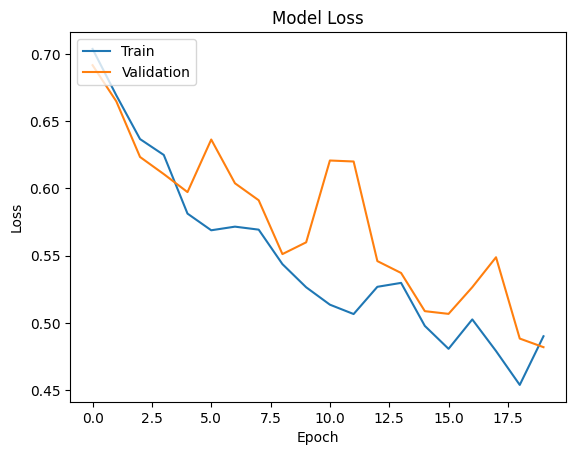

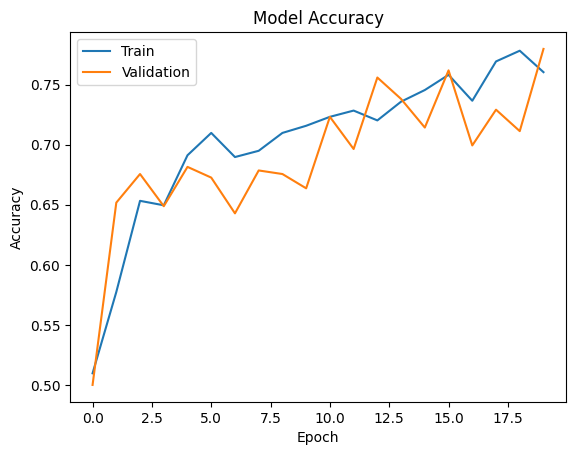

In [23]:
plot_training(history_hyperparameter)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Accuracy: 0.7058823529411765


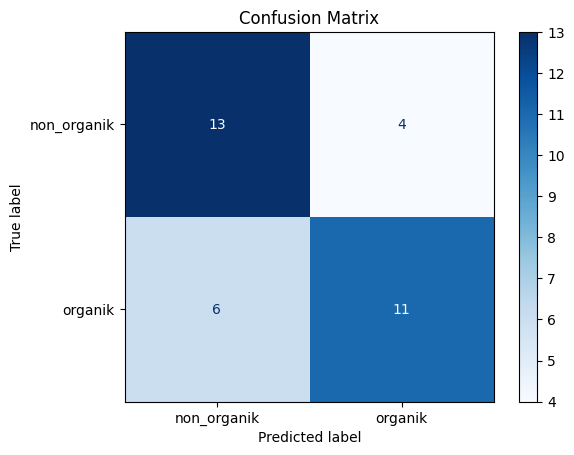

In [24]:
plot_cm(model=model_hyperparameter, test_generators=test_generators)

### Model: Architecture after Hyperparameter Tuning (New Model)

In [28]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrs_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [6]:
def create_model_new_hyperparameter():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [7]:
model_new_hyperparameter = create_model_new_hyperparameter()
model_new_hyperparameter.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 35, 35, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,052,737 (7.83 MB)

 Trainable params: 2,052,673 (7.83 MB)

 Non-trainable params: 64 (256.00 B)

#### Model: Neural Network New Model Process Visualization

1/1 [==============================] - 0s 402ms/step


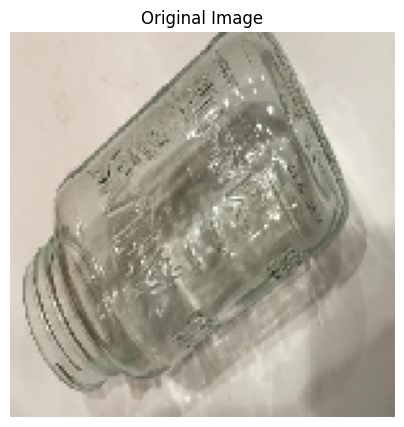

C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Kalea\AppData\Local\Temp\ipykernel_20932\2387671353.py:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


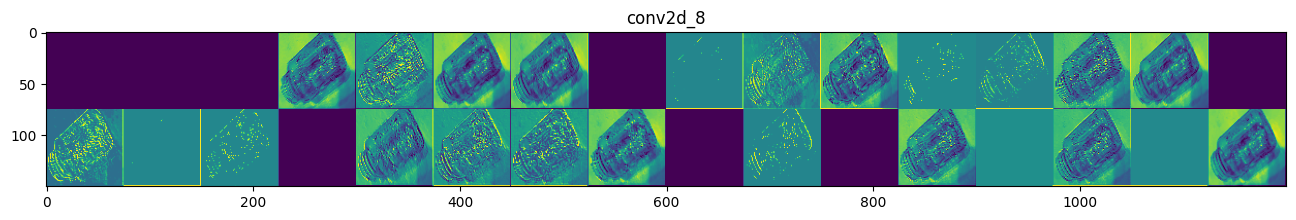

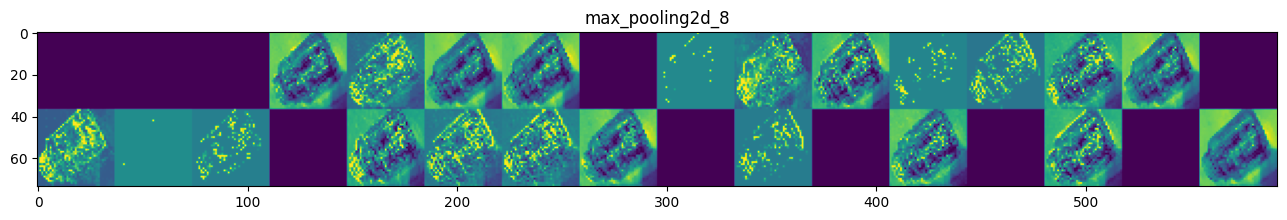

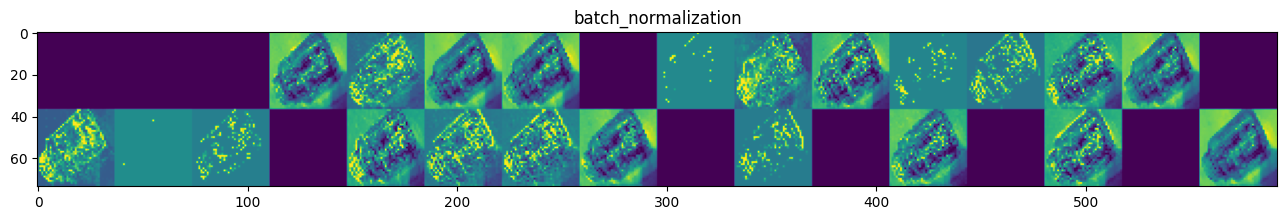

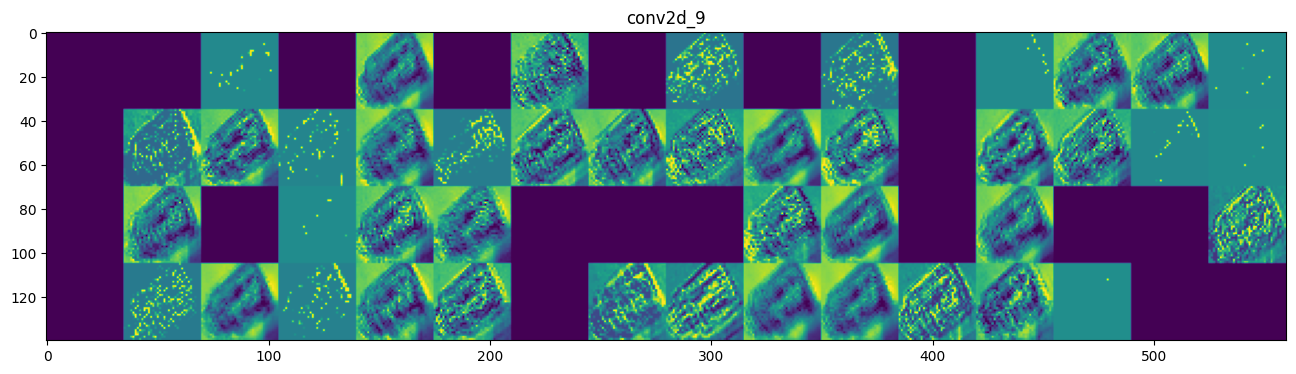

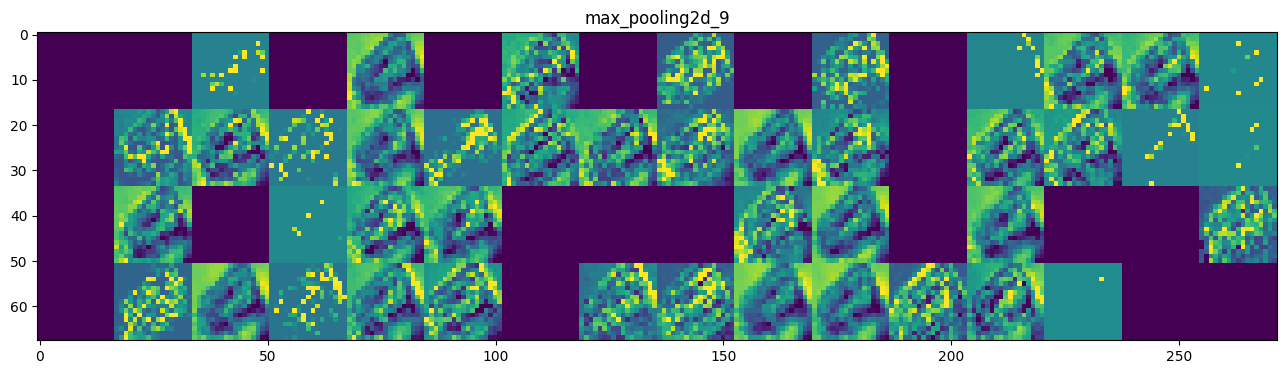

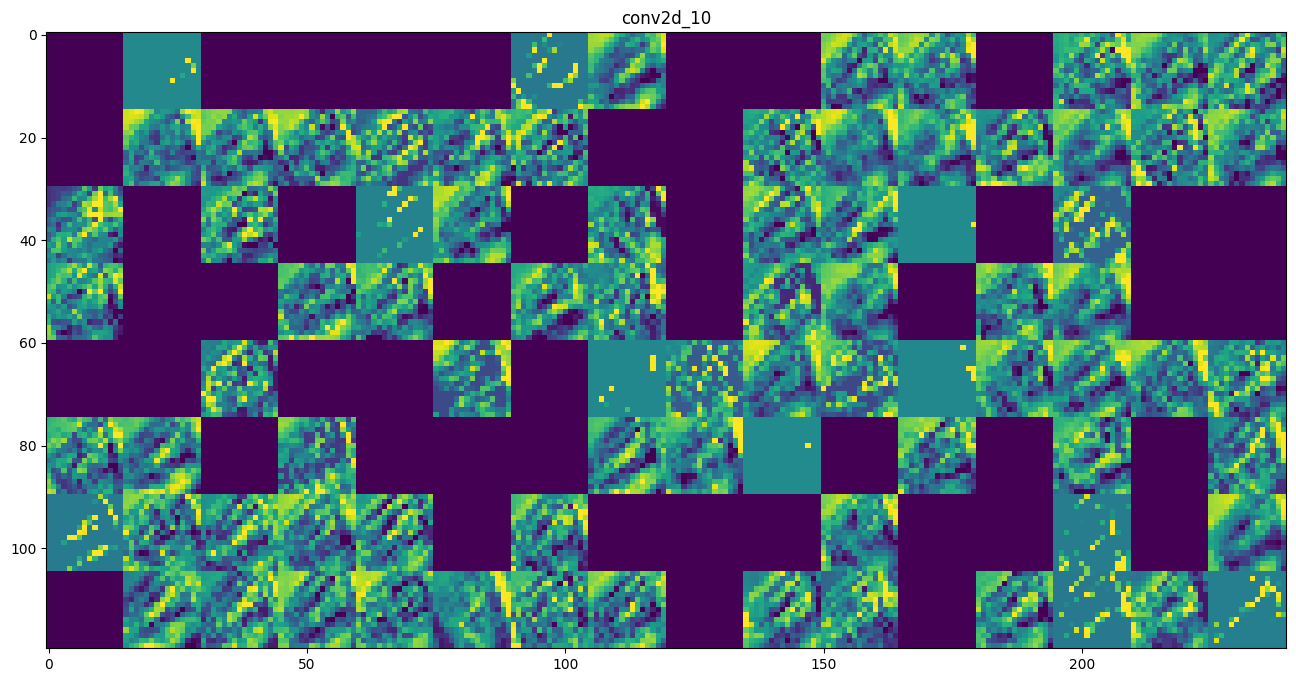

In [15]:
img_path = 'dataset/organic-nonorganic/validation/non_organik/glass35.jpg'
visualize_neural_network_process(img_path=img_path, model=model_new_hyperparameter)

In [57]:
history_new_hyperparameter = model_new_hyperparameter.fit(train_generators, epochs=50, verbose=1, validation_data=val_generators, workers=4, callbacks=[lrs_callback])

Epoch 1/50
21/21 [==============================] - 2s 63ms/step - loss: 0.6832 - accuracy: 0.6190 - val_loss: 0.6849 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 2s 67ms/step - loss: 0.5476 - accuracy: 0.7240 - val_loss: 0.6686 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 2s 62ms/step - loss: 0.4902 - accuracy: 0.7604 - val_loss: 0.7401 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 2s 67ms/step - loss: 0.4741 - accuracy: 0.7671 - val_loss: 0.6789 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 2s 69ms/step - loss: 0.4423 - accuracy: 0.8065 - val_loss: 0.6253 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 2s 70ms/step - loss: 0.4766 - accuracy: 0.7723 - val_loss: 0.6569 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 7/50
21/21 [==============================] - 2s 66ms/step - loss: 0.4

#### Model: Architecture after New Hyperparameter Tuning Evaluation

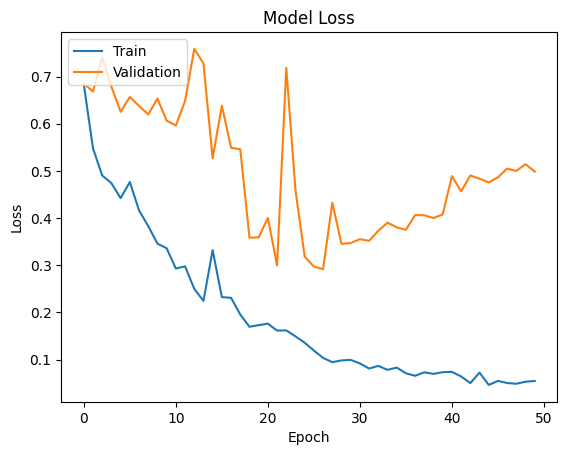

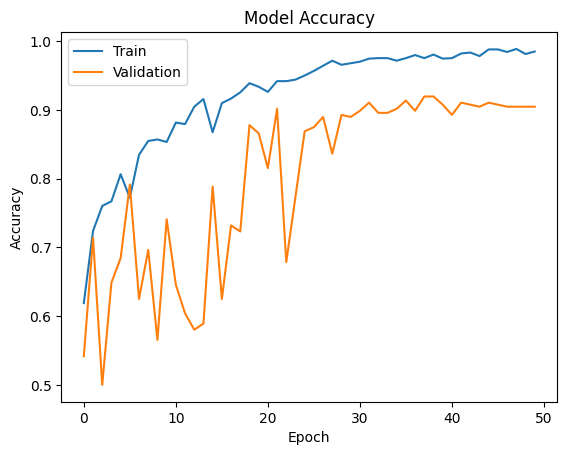

In [61]:
plot_training(history_new_hyperparameter)

2/2 [==============================] - 0s 3ms/step
Accuracy: 0.8529411764705882


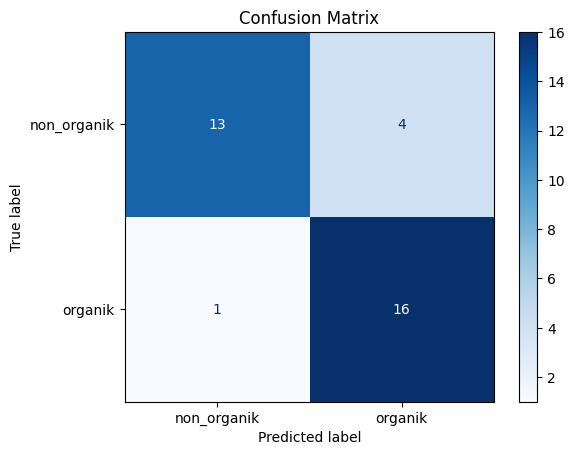

In [62]:
plot_cm(model=model_new_hyperparameter, test_generators=test_generators)

In [ ]:
model.save("model.h5")
model_hyperparameter.save("model_hyperparameter.h5")
model_new_hyperparameter.save("model_new_hyperparameter.h5")